## IF APPROACH

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf


# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("if_approach_month").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-03-09 12:33:27,261 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-03-09 12:33:28,433 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-03-09 12:33:30,385 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental f

[Database(name='2023_11_01', description='FactSet data snapshot for 2023_11_01', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_01'),
 Database(name='2023_11_02', description='FactSet data snapshot for 2023_11_02', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_02'),
 Database(name='2023_11_03', description='FactSet data snapshot for 2023_11_03', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_03'),
 Database(name='2023_11_14', description='FactSet data snapshot for 2023_11_14', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_14'),
 Database(name='2023_11_19', description='FactSet data snapshot for 2023_11_19', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_19'),
 Database(name='2023_11_22', description='FactSet data snapshot for 2023_11_22', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_22'),
 Database(name='2024_01_25', description='FactSet da

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 52910)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/spark/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/opt/spark/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/opt/spark/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile)
  File "/opt/spark/python/pyspark/serializers.py", line 564, in read_int
 

In [2]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F

spark.sql("USE 2023_11_02")
from pyspark.sql.functions import when
from datetime import datetime, timedelta


#### Helper Functions

In [3]:
from pyspark.sql.functions import when
from datetime import datetime, timedelta



In [4]:
import os

curr_dir = os.getcwd()
main_dir = os.path.dirname(curr_dir)
print(main_dir)

/home/ztewari/Stock-Implosion-Prediction-FYP


In [5]:
from CreateDataset import get_tabular_dataset_qf, get_feature_col_names, get_not_null_cols
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv
from sklearn.impute import SimpleImputer

def plot_nulls(df):
    null_counts = df.agg(*[
    (1 - (F.count(c) / F.count('*'))).alias(c + '_nulls') for c in df.columns])
    null_counts_pd = null_counts.toPandas().transpose()
    null_counts_pd.columns = ['null_percentage']

    # Plot the bar chart
    # null_counts_pd.plot(kind='bar', legend=False, figsize=(20, 6))
    # plt.title('Percentage of Null Values in Each Column')
    # plt.ylabel('Percentage of Null Values')
    # plt.xlabel('Columns')
    # plt.show()
    
    
    for c in feature_cols:
        median_value = df.approxQuantile(c, [0.5], 0.001)[0]
        df = df.withColumn(
            c, F.when(F.col(c).isNull(), median_value).otherwise(F.col(c))
        )
    return df.orderBy('fsym_id','date')


def get_df(fn, all_feats=False, imploded_only=False, prediction=False):
    df = get_tabular_dataset_qf(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.1)
    print("df retrieved")
    
    # null_counts_per_column = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns])

    return df
    
def write_features_file(data_list, csv_file_path='features.csv'):
    data_list = [data_list]
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in data_list:
            writer.writerow(row)
    print("Features written: ", data_list[0])

# df = get_df('imploded_stocks_price.csv')
df = get_df(f'{main_dir}/data/imploded_stocks_price2.csv', all_feats =True, prediction=False, imploded_only=False)
# plot_nulls(df)


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-03-09 12:34:05,893 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


['ff_assets_com_eq', 'ff_assets_eq', 'ff_assets_gr', 'ff_com_eq_tcap', 'ff_debt_com_eq', 'ff_debt_entrpr_val', 'ff_debt_eq', 'ff_debt_lt_cf', 'ff_debt_st_x_curr_port', 'ff_dil_adj', 'ff_fix_assets_com_eq', 'ff_inc_adj', 'ff_inc_sund', 'ff_int_exp_oth', 'ff_invest_cap', 'ff_ltd_com_eq', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_basic_beft_xord', 'ff_net_inc_dil', 'ff_net_inc_dil_aft_xord', 'ff_non_oper_exp', 'ff_oper_inc_aft_unusual', 'ff_oper_inc_tcap', 'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap', 'ff_tcap_assets', 'ff_tot_debt_tcap_std', 'ff_ut_gross_inc', 'ff_ut_operation_exp', 'ff_xord', 'ff_xord_disc', 'ff_ebit_bef_unusual', 'ff_ebitda_bef_unusual', 'ff_eps_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_bk_oper_inc_oth', 'ff_bk_oper_inc_tot', 'ff_commiss_inc_net', 'ff_accr_exp', 'GDP', 'Unemployment_Rate', 'CPI']
df retrieved


In [6]:
df = df.toPandas()

2024-03-09 12:34:34,759 ERROR scheduler.AsyncEventQueue: Listener EventLoggingListener threw an exception
java.util.ConcurrentModificationException
	at java.util.Hashtable$Enumerator.next(Hashtable.java:1408)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:424)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:420)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.mutable.MapLike.toSeq(MapLike.scala:75)
	at scala.collection.mutable.MapLike.toSeq$(MapLike.scala:72)
	at scala.collection.mutable.AbstractMap.toSeq(Map.scala:82)
	at org.apache.spark.scheduler.EventLoggingList

In [7]:
df.head()

,fsym_id,date,adj_price,Market_Value,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_com_eq_tcap,ff_debt_com_eq,ff_debt_entrpr_val,...,ff_net_inc_dil_bef_unusual,ff_bk_oper_inc_oth,ff_bk_oper_inc_tot,ff_commiss_inc_net,ff_accr_exp,GDP,Unemployment_Rate,CPI,Implosion_Start_Date,label
0,B00FG1-R,2014-05-30,12.937461,205537.443757,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
1,B00FG1-R,2014-06-30,13.309866,211453.848680,7.947306,7.947306,NaN,12.739965,684.931507,0.256353,...,5.417,0.0,0.0,0.0,0.0,0.006058,5.6,-0.003085,NaT,0
2,B00FG1-R,2014-07-31,12.434472,197546.455289,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
3,B00FG1-R,2014-08-29,12.151817,193055.920358,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
4,B00FG1-R,2014-09-30,12.327084,195840.380748,NaN,-7.616454,NaN,-13.214509,NaN,0.338172,...,9.308,0.0,0.0,0.0,0.0,0.006058,5.6,-0.003085,NaT,0


In [8]:
df[df['fsym_id']=='B06303-R']

,fsym_id,date,adj_price,Market_Value,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_com_eq_tcap,ff_debt_com_eq,ff_debt_entrpr_val,...,ff_net_inc_dil_bef_unusual,ff_bk_oper_inc_oth,ff_bk_oper_inc_tot,ff_commiss_inc_net,ff_accr_exp,GDP,Unemployment_Rate,CPI,Implosion_Start_Date,label
1204,B06303-R,2020-02-28,10020.000,8.796558e+06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-15,0
1205,B06303-R,2020-03-31,10020.000,8.796558e+06,NaN,-14.486705,-17.695566,-8.484574,NaN,0.001224,...,-0.878666,0.0,0.0,0.0,0.0,0.017409,6.7,0.004685,2021-10-15,0
1206,B06303-R,2020-04-30,37.700,3.309683e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-15,0
1207,B06303-R,2020-05-29,52.000,4.565080e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-15,0
1208,B06303-R,2020-06-30,50.000,4.389500e+04,NaN,-6.253215,-6.957559,-20.762510,NaN,0.177780,...,-3.530011,0.0,0.0,0.0,0.0,0.017409,6.7,0.004685,2021-10-15,0
1209,B06303-R,2020-07-31,42.000,3.909354e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-15,0
1210,B06303-R,2020-08-31,41.500,3.862814e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-15,0
1211,B06303-R,2020-09-30,41.700,3.881430e+04,NaN,-5.488216,-18.686387,-26.015747,NaN,0.175371,...,-0.027722,0.0,0.0,0.0,0.0,0.017409,6.7,0.004685,2021-10-15,0
1212,B06303-R,2020-10-30,41.500,3.862814e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-15,0
1213,B06303-R,2020-11-30,41.500,3.883472e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-15,0


In [9]:
print(len(df[df['label']==1]))

1290


In [10]:
df=df.drop('Implosion_Start_Date', axis=1)

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def correlation_matrix(df):
    # df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr().abs()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix_tab.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    corr_dict = {}
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                if corr_mat.columns[i] not in corr_dict.keys():
                    corr_dict[corr_mat.columns[i]] = [corr_mat.columns[j]]
                else:
                    corr_dict[corr_mat.columns[i]].append(corr_mat.columns[j])
                    
    for k,v in corr_dict.items():
        if len(corr_dict[k]) >= 1:
            for col in corr_dict[k]:
                if col in df.columns:
                    df=df.drop(col,axis=1)
    
                

    print(df.columns)
    return df

    
                
df=correlation_matrix(df) #pandas now
# df=correlation_matrix(df)

Converted to Pandas
Variable pairs with absolute correlation above 0.7:
Index(['fsym_id', 'date', 'adj_price', 'Market_Value', 'ff_assets_com_eq',
       'ff_assets_gr', 'ff_com_eq_tcap', 'ff_debt_entrpr_val', 'ff_debt_lt_cf',
       'ff_debt_st_x_curr_port', 'ff_dil_adj', 'ff_inc_adj', 'ff_inc_sund',
       'ff_int_exp_oth', 'ff_invest_cap', 'ff_ltd_tcap', 'ff_min_int_tcap',
       'ff_net_inc_basic_aft_xord', 'ff_non_oper_exp', 'ff_oper_inc_tcap',
       'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap', 'ff_tcap_assets',
       'ff_ut_operation_exp', 'ff_xord', 'ff_xord_disc', 'ff_eps_dil_aft_xord',
       'ff_bk_oper_inc_oth', 'ff_bk_oper_inc_tot', 'ff_accr_exp', 'GDP',
       'Unemployment_Rate', 'label'],
      dtype='object')


In [14]:
print(len(df.columns))
print(len(df['fsym_id'].unique()))

33
10826


In [15]:
# def convert_to_prediction(df):
#     df_temp = spark.createDataFrame(df)
#     ws = Window.partitionBy('fsym_id').orderBy(F.col('date').desc())
#     df_temp = df_temp.withColumn('label', F.lag(F.col('label')).over(ws))
#     # df_temp= df_temp.filter(F.col('label').isNotNull())
#     return df_temp

def convert_to_prediction(df1):
    for fsym_id, group in df1.groupby('fsym_id'):
        group = group.sort_values(by='date')
        df1.loc[group.index, 'label_shifted'] = group['label'].shift(-12)
    
    return df1

df = convert_to_prediction(df)

In [16]:
df[df['fsym_id']=='B06303-R']

,fsym_id,date,adj_price,Market_Value,ff_assets_com_eq,ff_assets_gr,ff_com_eq_tcap,ff_debt_entrpr_val,ff_debt_lt_cf,ff_debt_st_x_curr_port,...,ff_xord,ff_xord_disc,ff_eps_dil_aft_xord,ff_bk_oper_inc_oth,ff_bk_oper_inc_tot,ff_accr_exp,GDP,Unemployment_Rate,label,label_shifted
1204,B06303-R,2020-02-28,10020.000,8.796558e+06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1205,B06303-R,2020-03-31,10020.000,8.796558e+06,NaN,-17.695566,-8.484574,0.001224,0.000000,9.034122,...,0.0,0.0,-0.999068,0.0,0.0,0.0,0.017409,6.7,0,0.0
1206,B06303-R,2020-04-30,37.700,3.309683e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1207,B06303-R,2020-05-29,52.000,4.565080e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1208,B06303-R,2020-06-30,50.000,4.389500e+04,NaN,-6.957559,-20.762510,0.177780,0.318550,7.412621,...,0.0,0.0,-3.961373,0.0,0.0,0.0,0.017409,6.7,0,0.0
1209,B06303-R,2020-07-31,42.000,3.909354e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1210,B06303-R,2020-08-31,41.500,3.862814e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1211,B06303-R,2020-09-30,41.700,3.881430e+04,NaN,-18.686387,-26.015747,0.175371,0.070000,6.602158,...,0.0,0.0,-0.029646,0.0,0.0,0.0,0.017409,6.7,0,0.0
1212,B06303-R,2020-10-30,41.500,3.862814e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0
1213,B06303-R,2020-11-30,41.500,3.883472e+04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [17]:
df.drop('label', axis=1, inplace=True)
df.rename(columns={'label_shifted': 'label'}, inplace=True)

In [18]:
df[df['label']==1]

,fsym_id,date,adj_price,Market_Value,ff_assets_com_eq,ff_assets_gr,ff_com_eq_tcap,ff_debt_entrpr_val,ff_debt_lt_cf,ff_debt_st_x_curr_port,...,ff_ut_operation_exp,ff_xord,ff_xord_disc,ff_eps_dil_aft_xord,ff_bk_oper_inc_oth,ff_bk_oper_inc_tot,ff_accr_exp,GDP,Unemployment_Rate,label
602,B04CB3-R,2021-04-30,8.880000e+00,603241.044000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1142,B0592Z-R,2014-12-31,1.220000e+00,76579.400000,1.563547,-35.430184,100.000000,0.00000,-1.7,0.0,...,0.000000,0.000,0.000,-0.056030,0.0,0.000,6.688000,0.006058,5.6,1.0
1212,B06303-R,2020-10-30,4.150000e+01,38628.137750,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1577,B0CXCV-R,2018-12-31,6.840000e+03,52551.720000,1.415922,271.038353,100.000000,0.00000,0.0,0.0,...,0.346725,0.000,0.000,-356.475689,0.0,0.076,0.660945,0.005728,3.9,1.0
1606,B0P5YF-R,2019-03-29,6.440000e+01,415972.480000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226231,XP9YT2-R,2011-10-31,1.631998e+03,126615.860350,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1226323,XPB689-R,2013-03-29,1.120000e+11,28659.120000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1227958,XQC216-R,2020-12-31,3.810000e+00,79635.488430,NaN,-0.514225,-2.236512,0.65977,0.0,0.0,...,16.634000,-17.776,-17.776,-0.479578,0.0,0.000,0.000000,0.017409,6.7,1.0
1229920,XQGHLF-R,2016-10-31,3.200000e+01,248659.200000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [17]:
# df['date'] = pd.to_datetime(df['date'])
# df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df[feats] = df.groupby(['year', 'month'])[feats].transform(lambda x: x.fillna(x.mean()))

In [19]:
df.isnull().sum()

fsym_id                           0
date                              0
adj_price                         0
Market_Value                    396
ff_assets_com_eq             986724
ff_assets_gr                 989282
ff_com_eq_tcap               979828
ff_debt_entrpr_val           980521
ff_debt_lt_cf                993646
ff_debt_st_x_curr_port       985067
ff_dil_adj                   979342
ff_inc_adj                   976468
ff_inc_sund                  976871
ff_int_exp_oth               984868
ff_invest_cap                978668
ff_ltd_tcap                  980785
ff_min_int_tcap              982852
ff_net_inc_basic_aft_xord    979040
ff_non_oper_exp              995839
ff_oper_inc_tcap             990380
ff_oper_ps_net_cf            992747
ff_pfd_stk_tcap              981156
ff_tcap_assets               977775
ff_ut_operation_exp          977753
ff_xord                      978135
ff_xord_disc                 978135
ff_eps_dil_aft_xord          988153
ff_bk_oper_inc_oth          

In [19]:
# from CreateDataset import get_fund_data_monthly
# q = """SELECT a.fsym_id,a.date FROM FF_ADVANCED_DER_QF a WHERE a.fsym_id = 'B0CXCV-R' """
# q_df = spark.sql(q)
# idk_df = get_fund_data_monthly(q_df)
# idk_df.show()

In [20]:
# df = df.dropna(subset=['label'])
# len(df[df['label'] == 1])

In [20]:
df[df['fsym_id']=='B0CXCV-R'].head(100)

,fsym_id,date,adj_price,Market_Value,ff_assets_com_eq,ff_assets_gr,ff_com_eq_tcap,ff_debt_entrpr_val,ff_debt_lt_cf,ff_debt_st_x_curr_port,...,ff_ut_operation_exp,ff_xord,ff_xord_disc,ff_eps_dil_aft_xord,ff_bk_oper_inc_oth,ff_bk_oper_inc_tot,ff_accr_exp,GDP,Unemployment_Rate,label
1572,B0CXCV-R,2018-07-31,9500.0000,70129.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1573,B0CXCV-R,2018-08-31,9700.0000,71605.400000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1574,B0CXCV-R,2018-09-28,8600.0000,65661.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1575,B0CXCV-R,2018-10-31,10239.9980,78182.384730,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1576,B0CXCV-R,2018-11-30,8800.0000,67610.400000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1577,B0CXCV-R,2018-12-31,6840.0000,52551.720000,1.415922,271.038353,100.000000,0.0,0.0,0.0,...,0.346725,0.0,0.0,-356.475689,0.0,0.076,0.660945,0.005728,3.9,1.0
1578,B0CXCV-R,2019-01-31,6520.0000,50093.160000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1579,B0CXCV-R,2019-02-28,4720.0000,36263.760000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1580,B0CXCV-R,2019-03-29,3980.0000,30825.100000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1581,B0CXCV-R,2019-04-30,3407.8000,26393.411000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    feats = train_df.columns[2:-1]
    train_df['date'] = pd.to_datetime(train_df['date'])
    train_df['year'] = train_df['date'].dt.year
    train_df[feats] = train_df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.mean()))
    train_df=train_df.drop('year', axis=1)
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        counter = Counter(y_train)
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        model = xgb.XGBClassifier(scale_pos_weight=estimate)
        
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=1, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 10:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'xgb')
# gbt_feats = boruta_fs(df, 'gbt')

Estimate: 979.664


ValueError: Input y contains NaN.

In [ ]:
# df = df[rf_feats + ['fsym_id', 'date', 'label']]

In [22]:
# df = df.drop('year', axis=1)
feats = df.drop(['fsym_id', 'date', 'label'], axis=1).columns.tolist()

In [23]:
from sklearn.feature_selection import VarianceThreshold

# Instantiate the VarianceThreshold selector
selector = VarianceThreshold(0.1)

# Fit the selector on the training data
selector.fit(df[feats])

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

selected_column_names = df[feats].columns[selected_indices]
print(len(selected_column_names))

30


In [24]:
df.columns

Index(['fsym_id', 'date', 'adj_price', 'Market_Value', 'ff_assets_com_eq',
       'ff_assets_gr', 'ff_com_eq_tcap', 'ff_debt_entrpr_val', 'ff_debt_lt_cf',
       'ff_debt_st_x_curr_port', 'ff_dil_adj', 'ff_inc_adj', 'ff_inc_sund',
       'ff_int_exp_oth', 'ff_invest_cap', 'ff_ltd_tcap', 'ff_min_int_tcap',
       'ff_net_inc_basic_aft_xord', 'ff_non_oper_exp', 'ff_oper_inc_tcap',
       'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap', 'ff_tcap_assets',
       'ff_ut_operation_exp', 'ff_xord', 'ff_xord_disc', 'ff_eps_dil_aft_xord',
       'ff_bk_oper_inc_oth', 'ff_bk_oper_inc_tot', 'ff_accr_exp', 'GDP',
       'Unemployment_Rate', 'label', 'year'],
      dtype='object')

In [25]:
df.head()

,fsym_id,date,adj_price,Market_Value,ff_assets_com_eq,ff_assets_gr,ff_com_eq_tcap,ff_debt_entrpr_val,ff_debt_lt_cf,ff_debt_st_x_curr_port,...,ff_xord,ff_xord_disc,ff_eps_dil_aft_xord,ff_bk_oper_inc_oth,ff_bk_oper_inc_tot,ff_accr_exp,GDP,Unemployment_Rate,label,year
0,B00FG1-R,2014-05-30,12.937461,205537.443757,5.564969,4435.103728,55.304585,0.256217,53.303505,1209.663155,...,0.078243,1.261652,-3155.351250,-18.739462,39.507369,210.645598,0.006058,5.6,0.0,2014
1,B00FG1-R,2014-06-30,13.309866,211453.848680,7.947306,4435.103728,12.739965,0.256353,297.707000,0.000000,...,0.000000,0.000000,0.170483,0.000000,0.000000,0.000000,0.006058,5.6,0.0,2014
2,B00FG1-R,2014-07-31,12.434472,197546.455289,5.564969,4435.103728,55.304585,0.256217,53.303505,1209.663155,...,0.078243,1.261652,-3155.351250,-18.739462,39.507369,210.645598,0.006058,5.6,0.0,2014
3,B00FG1-R,2014-08-29,12.151817,193055.920358,5.564969,4435.103728,55.304585,0.256217,53.303505,1209.663155,...,0.078243,1.261652,-3155.351250,-18.739462,39.507369,210.645598,0.006058,5.6,0.0,2014
4,B00FG1-R,2014-09-30,12.327084,195840.380748,5.564969,4435.103728,-13.214509,0.338172,104.954000,0.000000,...,0.000000,0.000000,0.292877,0.000000,0.000000,0.000000,0.006058,5.6,0.0,2014


In [25]:
# merged_df.drop('year', axis=1, inplace=True)
feats = df.drop(['fsym_id','label', 'date'], axis=1).columns.tolist()
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))

In [ ]:
# mask = (df['label'] == 0) & (df.isnull().any(axis=1)) #remove the null values with majority class only - this is fine to do for the training set, but not the test set

# df = df[~mask]

In [ ]:
# df['date'] = pd.to_datetime(df['date'])
# df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df[feats] = df.groupby(['year', 'month'])[feats].transform(lambda x: x.fillna(x.mean()))
# df.drop(['year', 'month'], axis=1, inplace=True)

In [26]:
df.isnull().sum()

fsym_id                           0
date                              0
adj_price                         0
Market_Value                      0
ff_assets_com_eq             107982
ff_assets_gr                 111466
ff_capex_assets              133602
ff_capex_ps_cf               138213
ff_cash_div_cf               131233
ff_cash_roce                 142540
ff_cf_sales                  170501
ff_com_eq_gr                 112982
ff_com_eq_tcap               104702
ff_debt_entrpr_val           110674
ff_debt_lt_cf                134524
ff_debt_st_x_curr_port       105226
ff_dil_adj                   105505
ff_earn_yld                  118837
ff_inc_adj                   103853
ff_inc_sund                  103706
ff_int_exp_oth               106402
ff_invest_cap                103824
ff_invest_lt                 113401
ff_ltd_tcap                  104721
ff_min_int_tcap              104914
ff_mkt_val_gr                124549
ff_net_inc_basic_aft_xord    104520
ff_net_inc_bef_xord_gr      

In [27]:
df = df.set_index('date')
df=df.sort_index()

In [28]:
%%capture
import warnings
warnings.filterwarnings("ignore")
import tsfel

def create_windows(df):
    cfg = tsfel.get_features_by_domain(domain='statistical', json_path='features3.json')
    result_dfs = []
    for fsym_id, group in df.groupby('fsym_id'):
        for i in range(60, len(group)+1, 12):
            window = group.iloc[:i]
            X = tsfel.time_series_features_extractor(cfg, window.drop(['fsym_id', 'label'], axis=1), verbose=0)
            X['fsym_id'] = window['fsym_id'].iloc[0]
            # X['label'] = window['label'].sum()
            X['end_date'] = window.index[-1]
            result_dfs.append(X)
            
    final_result = pd.concat(result_dfs, ignore_index=True)
    final_result.reset_index(drop=True, inplace=True)
    return final_result
        
        

new_df = create_windows(df)

KeyboardInterrupt: 

In [35]:


def create_winows(df):
    counter = 0
    for fsym_id, group in df.groupby('fsym_id'):
        if len(group) >= 60 and group['label'].sum()==1:
            print(fsym_id)
            counter+=1
    print(counter)
        
        
        

# create_winows(df)

In [ ]:
new_df.head()

In [30]:
exclude_cols = ['fsym_id',  'end_date']
feats = new_df.drop(exclude_cols, axis=1).columns
feats

Index(['GDP_Max', 'Market_Value_Max', 'Unemployment_Rate_Max', 'adj_price_Max',
       'ff_accr_exp_Max', 'ff_assets_com_eq_Max', 'ff_assets_gr_Max',
       'ff_bk_oper_inc_oth_Max', 'ff_bk_oper_inc_tot_Max',
       'ff_capex_assets_Max', 'ff_capex_ps_cf_Max', 'ff_cash_div_cf_Max',
       'ff_cash_roce_Max', 'ff_cf_roic_Max', 'ff_cf_sales_Max',
       'ff_com_eq_gr_Max', 'ff_com_eq_tcap_Max', 'ff_debt_entrpr_val_Max',
       'ff_debt_lt_cf_Max', 'ff_debt_st_x_curr_port_Max', 'ff_dil_adj_Max',
       'ff_div_yld_Max', 'ff_earn_yld_Max', 'ff_fcf_yld_Max', 'ff_inc_adj_Max',
       'ff_inc_sund_Max', 'ff_int_exp_oth_Max', 'ff_invest_cap_Max',
       'ff_invest_lt_Max', 'ff_liabs_lease_Max', 'ff_ltd_tcap_Max',
       'ff_min_int_tcap_Max', 'ff_mkt_val_gr_Max',
       'ff_net_inc_basic_aft_xord_Max', 'ff_net_inc_bef_xord_gr_Max',
       'ff_non_oper_exp_Max', 'ff_oper_inc_tcap_Max', 'ff_oper_ps_net_cf_Max',
       'ff_pfd_stk_tcap_Max', 'ff_roa_ptx_Max', 'ff_std_debt_Max',
       'ff_tang_as

In [31]:
new_df.head()

,GDP_Max,Market_Value_Max,Unemployment_Rate_Max,adj_price_Max,ff_accr_exp_Max,ff_assets_com_eq_Max,ff_assets_gr_Max,ff_bk_oper_inc_oth_Max,ff_bk_oper_inc_tot_Max,ff_capex_assets_Max,...,ff_std_debt_Max,ff_tang_assets_debt_Max,ff_tcap_assets_Max,ff_ut_operation_exp_Max,ff_wkcap_Max,ff_wkcap_pct_Max,ff_xord_Max,ff_xord_disc_Max,fsym_id,end_date
0,0.017494,9.298864e+05,5.6,15.401880,0.000,40.321823,1210.946360,0.0,0.0,18.371459,...,23.800631,141.094183,99.356469,26.983,65.800,14.859009,0.0,0.0,B00FG1-R,2019-04-30
1,0.017494,1.004034e+06,6.7,16.057889,57.775,40.321823,1210.946360,0.0,0.0,18.371459,...,23.800631,141.094183,99.356469,31.789,156.565,15.485662,0.0,0.0,B00FG1-R,2020-04-30
2,0.034648,1.004034e+06,6.7,16.057889,57.775,40.321823,1210.946360,0.0,0.0,18.371459,...,23.800631,141.094183,99.356469,31.789,156.565,15.485662,0.0,0.0,B00FG1-R,2021-04-30
3,0.034648,1.004034e+06,6.7,16.057889,57.775,40.321823,1210.946360,0.0,0.0,18.371459,...,23.800631,149.497794,99.356469,31.789,156.565,15.485662,0.0,0.0,B00FG1-R,2022-04-29
4,0.018033,2.301596e+07,6.0,71.592423,608.700,2.423375,27.469544,0.0,0.0,7.385365,...,45.813107,862.202381,83.222298,258.500,2679.200,60.872924,4.9,4.9,B01DPB-R,2004-12-31


In [32]:
len(new_df['fsym_id'].unique())

6071

In [34]:
df.head()

,fsym_id,adj_price,Market_Value,ff_assets_com_eq,ff_assets_gr,ff_capex_assets,ff_capex_ps_cf,ff_cash_div_cf,ff_cash_roce,ff_cf_sales,...,ff_bk_oper_inc_oth,ff_bk_oper_inc_tot,ff_cf_roic,ff_div_yld,ff_liabs_lease,ff_fcf_yld,ff_accr_exp,GDP,Unemployment_Rate,label
date,,,,,,,,,,,,,,,,,,,,,
2000-01-06,KKTDLP-R,10.8750,2.358788e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,C0X2D7-R,49.8750,1.504529e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,JS52R8-R,23.4375,2.238891e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,X1W0W7-R,12.1875,1.433859e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-12,R4QG9V-R,71.3125,1.425394e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df['year'] = pd.to_datetime(df.index).year
grouped_df = df.groupby(['fsym_id', 'year'])['label'].sum()
grouped_df.head()

fsym_id   year
B00FG1-R  2014    0.0
          2015    0.0
          2016    0.0
          2017    0.0
          2018    0.0
Name: label, dtype: float64

In [40]:
gp = pd.DataFrame(grouped_df).reset_index()
print(gp.head())
num_years = gp.groupby('fsym_id')['year'].count()
print(num_years.head())

    fsym_id  year  label
0  B00FG1-R  2014    0.0
1  B00FG1-R  2015    0.0
2  B00FG1-R  2016    0.0
3  B00FG1-R  2017    0.0
4  B00FG1-R  2018    0.0
fsym_id
B00FG1-R     9
B01DPB-R     7
B01HWF-R    22
B03JRB-R     1
B04CB3-R    16
Name: year, dtype: int64


In [224]:
num_years['B15GK7-R']

2

In [36]:
grouped_df[grouped_df==1].head()

fsym_id   year
B04CB3-R  2021    1.0
B0592Z-R  2014    1.0
B06303-R  2020    1.0
B0CXCV-R  2018    1.0
B0P5YF-R  2019    1.0
Name: label, dtype: float64

In [37]:
len(grouped_df[grouped_df==1])

1125

In [38]:

# Assuming df2 has an 'end_date' column
new_df['year'] = pd.to_datetime(new_df['end_date']).dt.year

# Joining the two DataFrames based on the 'Year' column
merged_df = pd.merge(new_df, grouped_df, how='inner', left_on=['fsym_id','year'], right_on=['fsym_id','year'])

# Drop the 'Year' column if not needed in the final result
# merged_df = merged_df.drop(columns=['year'])

In [39]:
merged_df.head()

,GDP_Max,Market_Value_Max,Unemployment_Rate_Max,adj_price_Max,ff_accr_exp_Max,ff_assets_com_eq_Max,ff_assets_gr_Max,ff_bk_oper_inc_oth_Max,ff_bk_oper_inc_tot_Max,ff_capex_assets_Max,...,ff_tcap_assets_Max,ff_ut_operation_exp_Max,ff_wkcap_Max,ff_wkcap_pct_Max,ff_xord_Max,ff_xord_disc_Max,fsym_id,end_date,year,label
0,0.017494,9.298864e+05,5.6,15.401880,0.000,40.321823,1210.946360,0.0,0.0,18.371459,...,99.356469,26.983,65.800,14.859009,0.0,0.0,B00FG1-R,2019-04-30,2019,0.0
1,0.017494,1.004034e+06,6.7,16.057889,57.775,40.321823,1210.946360,0.0,0.0,18.371459,...,99.356469,31.789,156.565,15.485662,0.0,0.0,B00FG1-R,2020-04-30,2020,0.0
2,0.034648,1.004034e+06,6.7,16.057889,57.775,40.321823,1210.946360,0.0,0.0,18.371459,...,99.356469,31.789,156.565,15.485662,0.0,0.0,B00FG1-R,2021-04-30,2021,0.0
3,0.034648,1.004034e+06,6.7,16.057889,57.775,40.321823,1210.946360,0.0,0.0,18.371459,...,99.356469,31.789,156.565,15.485662,0.0,0.0,B00FG1-R,2022-04-29,2022,0.0
4,0.018033,2.301596e+07,6.0,71.592423,608.700,2.423375,27.469544,0.0,0.0,7.385365,...,83.222298,258.500,2679.200,60.872924,4.9,4.9,B01DPB-R,2004-12-31,2004,0.0


In [40]:
merged_df.drop('year', axis=1,inplace=True)
merged_df[merged_df['label']==1]

,GDP_Max,Market_Value_Max,Unemployment_Rate_Max,adj_price_Max,ff_accr_exp_Max,ff_assets_com_eq_Max,ff_assets_gr_Max,ff_bk_oper_inc_oth_Max,ff_bk_oper_inc_tot_Max,ff_capex_assets_Max,...,ff_tang_assets_debt_Max,ff_tcap_assets_Max,ff_ut_operation_exp_Max,ff_wkcap_Max,ff_wkcap_pct_Max,ff_xord_Max,ff_xord_disc_Max,fsym_id,end_date,label
31,0.034648,9.224847e+05,9.9,1.499998e+01,7.328000,3.784266,703884.482759,0.000,0.000,11.044743,...,13124.193548,80.229592,5.826000,43.463000,95.944812,0.000000,0.000000,B04CB3-R,2021-05-31,1.0
62,0.018033,5.315840e+05,9.9,3.550000e+01,25.759000,58.632443,72.367694,0.000,258.000,30.780934,...,200572.972973,89.190071,18.049000,118.694000,446.251862,0.000000,0.000000,B0592Z-R,2014-12-31,1.0
132,0.018033,5.208438e+03,6.0,2.975000e+02,0.000000,NaN,154.046243,0.000,0.000,0.000000,...,2.208503,57.142857,0.004860,-0.006732,-7756.000000,0.000000,0.000000,B15GK7-R,2005-12-30,1.0
229,0.014006,1.675830e+05,9.9,4.320818e+02,3.098358,1.369574,590.961164,0.000,0.000,0.365137,...,8685.359960,95.902094,0.123840,79.278449,106.923397,0.000000,0.000000,B1CVR7-R,2012-04-30,1.0
271,0.018033,1.081222e+06,6.0,4.299000e+01,85.740000,5.774264,62.156005,0.000,1000.000,10.826561,...,12064.978111,73.799629,94.826000,110.899000,37.988346,15.562000,15.562000,B29X4H-R,2007-12-31,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63572,0.014006,1.339732e+06,9.9,1.371692e+04,11.478642,1.428485,112.289998,0.000,0.000,NaN,...,4212.826676,90.343089,154.468595,285.830091,81.356102,9.369781,9.369781,XP9YT2-R,2011-11-30,1.0
63575,0.014006,2.805202e+05,9.9,4.972000e+12,10.489871,1.305910,341.264067,0.000,0.000,33.193904,...,3300.324020,99.002712,5.278938,113.174159,83.736190,0.000000,0.000000,XPB689-R,2013-07-31,1.0
63658,0.018033,5.981064e+05,9.9,2.592108e+01,13.857814,168.134115,68.693288,0.000,0.000,10.220050,...,111520.394737,91.737081,88.919660,156.677138,68.656059,0.000000,0.000000,XQC216-R,2020-12-31,1.0
63777,0.014049,6.687368e+05,9.9,2.213000e+02,91.639000,3.880720,29.099085,0.000,0.000,20.616368,...,1032.197964,74.584540,2034.899000,395.184000,50.163335,0.000000,0.000000,XQGHLF-R,2016-12-30,1.0


In [41]:
merged_df['label'] = merged_df['label'].astype(int)

In [42]:
from sklearn.feature_selection import VarianceThreshold

# Instantiate the VarianceThreshold selector
selector = VarianceThreshold(0.1)
feats = merged_df.drop(['fsym_id', 'end_date', 'label'], axis=1).columns.tolist()
# Fit the selector on the training data
selector.fit(merged_df[feats])

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

selected_column_names = merged_df[feats].columns[selected_indices]
print(len(selected_column_names))


corr_features = tsfel.correlated_features(merged_df[feats])
merged_df.drop(corr_features, axis=1, inplace=True)


47


In [ ]:
# df['date'] = pd.to_datetime(df['date'])
# df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df[feats] = df.groupby(['year', 'month'])[feats].transform(lambda x: x.fillna(x.mean()))

In [43]:
merged_df=merged_df.reset_index()

In [44]:
merged_df.drop('index', axis=1, inplace=True)

In [45]:
print(len(merged_df.columns))
print(len(merged_df))
print(len(merged_df[merged_df['label']==1]))

48
63784
420


In [41]:
# import os
# import pandas as pd

# train_file = 'train_df_if.csv'
# test_file = 'test_df_if.csv'

# # Check if the files exist
# if not (os.path.exists(train_file) and os.path.exists(test_file)):
#     # Write DataFrames to files
#     train_df.to_csv(train_file, index=False)
#     test_df.to_csv(test_file, index=False)
# else:
#     # Read DataFrames from existing files
#     print("works")
#     train_df = pd.read_csv(train_file, index_col=False)
#     test_df = pd.read_csv(test_file, index_col=False)

In [42]:
# train_df = train_df.iloc[:, 1:]
# test_df = test_df.iloc[:, 1:]
# test_df.head()

In [43]:
# train_df2 = spark.createDataFrame(train_df)
# test_df2 = spark.createDataFrame(test_df)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree
import shap
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from collections import Counter
from hyperopt.early_stop import no_progress_loss
from functools import reduce
# import lightgbm
import datetime
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

current_date = datetime.datetime.now()
current_date= current_date.strftime("%Y-%m-%d") 

def feature_importances(model, features, model_name):
    feature_importances = model.feature_importances_

    sorted_idx = np.argsort(feature_importances)[::-1]  # Sorting in descending order
    top_features = sorted_idx  # Selecting top 20 features
    top_feature_importances = feature_importances[top_features]
    top_sorted_features = [features[i] for i in top_features]

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(top_features)), top_feature_importances, align="center")
    plt.xticks(range(len(top_features)), top_sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title(f"All Feature Importances for {model_name}")
    plt.tight_layout()
    plt.savefig(f'results_when/{model_name}_all_feature_importances.png')
    plt.show()

    return top_sorted_features

def model_testing(df, classifier):
    seed = 42

    df = df.set_index('end_date')
    df = df.sort_index()
    
    exclude_columns = ['fsym_id', 'label']
    X_train = df.drop(exclude_columns, axis=1)
    y_train = df['label']

    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag', random_state=seed)
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        X_test[feats] = scaler.transform(X_test[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
            'max_depth': hp.quniform('max_depth', 5, 1200, 1),
            'max_features': hp.choice('max_features', [ 'sqrt','log2', None]),
            'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
            'min_samples_split' : hp.uniform ('min_samples_split', 0, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict, random_state=seed)
    elif classifier == 'GBT':
        param_space = { 'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.quniform('max_depth',5,20,1),
           'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,1),
           'min_samples_split':hp.quniform('min_samples_split',2,6,1)}
        classifier_instance = GradientBoostingClassifier()
    elif classifier == 'XGB':
        param_space = { 'n_estimators':hp.quniform('n_estimators',100,1000,1),
                        'max_depth':hp.quniform('max_depth',5,1200,1),
                       'eta': hp.quniform('eta', 0.025, 1, 0.025),
                       'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
                        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
                        'gamma': hp.quniform('gamma', 0.5, 5, 0.05),
                        'colsample_bytree': hp.quniform('colsample_bytree', 0, 1, 0.05)
                      }
        counter = Counter(y_train)
        # estimate scale_pos_weight value
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        
        classifier_instance = xgb.XGBClassifier(scale_pos_weight=estimate, seed=seed)
    else:
        raise ValueError("Unsupported classifier")
        
    tscv = TimeSeriesSplit(n_splits=3)
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'XGB':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        
        else:
            return params
    
    obj_scores = []
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        # classifier_instance.fit(X_train, y_train)
        scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='matthews_corrcoef')
        # y_pred = classifier_instance.predict(X_test)
        # score = matthews_corrcoef(y_test, y_pred)
        obj_scores.append(scores.mean())
        return -scores.mean()

    def report_average(*args):
        report_list = list()
        for report in args:
            splited = [' '.join(x.split()) for x in report.split('\n\n')]
            header = [x for x in splited[0].split(' ')]
            data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
            data = np.delete(data, 0, 1).astype(float)
            rest = splited[2].split(' ')
            accuarcy =np.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
            macro_avg = np.array([rest[5:9]]).astype(float).reshape(-1, len(header))
            weighted_avg = np.array([rest[11:]]).astype(float).reshape(-1, len(header))
            #avg_total = np.array([x for x in avg]).astype(float).reshape(-1, len(header))
            df = pd.DataFrame(np.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
            report_list.append(df)
        res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
        # res.to_csv(f'when_{classifier}_results.csv')
        return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})
    
    
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(10))
#     print(f"Best params:{best_params}")
#     best_params = set_params(classifier, best_params)
#     classifier_instance.set_params(**best_params)
#     i = 0
#     all_reports = []
#     plt.figure(figsize=(5,5))
#     plt.plot(obj_scores)
#     plt.show()
    
#     classifier_instance.fit(X_train, y_train)
#     preds = classifier_instance.predict(X_test)
#     final_report = classification_report(y_test, preds)
#     mcc = matthews_corrcoef(y_test, preds)
#     filename = f'results_when/report_{classifier}_when'
#     existing_mcc = None
#     try:
#         with open(filename, 'r') as f:
#             lines = f.readlines()
#             for line in lines:
#                 if line.startswith('MCC:'):
#                     existing_mcc = float(line.split(':')[1])
#                     break
#     except FileNotFoundError:
#         pass

#     # Overwriting file only if new MCC is larger
#     if existing_mcc is None or mcc > existing_mcc:
#         with open(filename, 'w') as f:
#             f.write(final_report)
#             f.write('\nMCC: ' + str(mcc))
#             f.write('\nHyperparams: ' + str(best_params))
    
# #     for train_index, test_index in tscv.split(X_train):
# #         x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
# #         Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
# #         classifier_instance.fit(x_train, Y_train)
        
# #         preds = classifier_instance.predict(x_test)
# #         report = classification_report(Y_test, preds)
# #         print(report)
# #         all_reports.append(report)
#     cm = confusion_matrix(y_test, preds, labels=classifier_instance.classes_)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title("Confusion Matrix")
#     plt.show()
#     test_df_full = test_df.copy()
#     test_df_full['preds'] = preds

#     return classifier_instance, X_train.columns.tolist(), X_train, X_test, test_df_full


model, feats, X_train, X_test, test_df_with_preds = model_testing(merged_df, 'XGB')

{0: 0.5033141847105612, 1: 75.93333333333334}
Estimate: 150.867
 11%|█         | 11/100 [01:31<12:17,  8.28s/trial, best loss: -0.08974007804882943]


KeyboardInterrupt: 

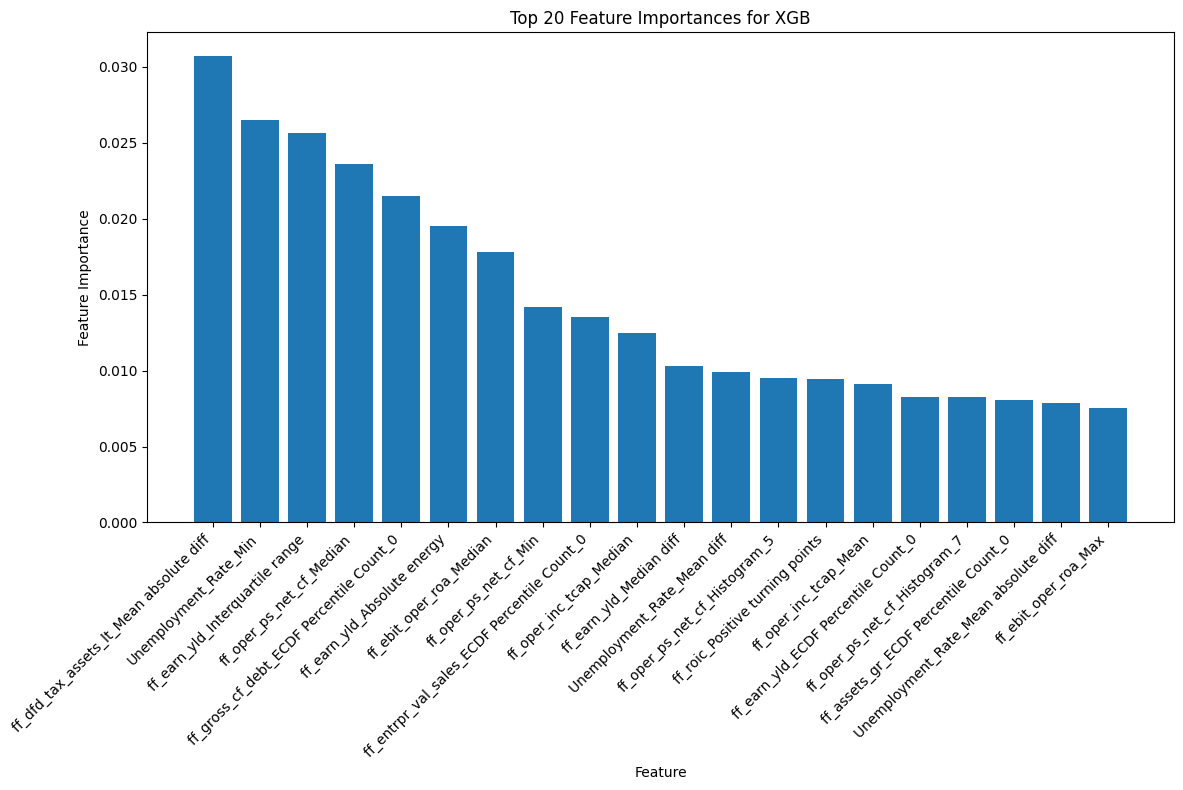

In [42]:
top_feats = feature_importances(model,feats, 'XGB')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


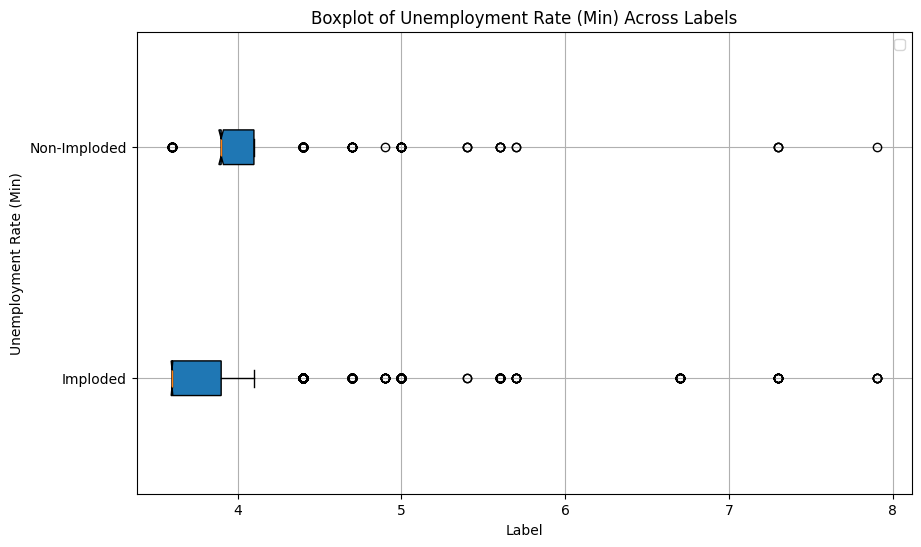

In [162]:
import seaborn as sns

# Assuming 'df' is your DataFrame and 'column_name' is the name of the column you want to plot
plt.figure(figsize=(10, 6))

plt.boxplot([train_df[train_df['label'] == 0]['Unemployment_Rate_Min'], 
                 train_df[train_df['label'] == 1]['Unemployment_Rate_Min']],
                labels=['Imploded', 'Non-Imploded'], vert=False, notch=True, patch_artist=True)

plt.xlabel('Label')  # Label for x-axis
plt.ylabel('Unemployment Rate (Min)')  # Label for y-axis
plt.title('Boxplot of Unemployment Rate (Min) Across Labels')  # Title of the plot
plt.grid(True)  # Show grid
plt.legend()  
plt.savefig('results_if/unemployment_box_plot_if.png')# Show legend
plt.show()


In [57]:
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Define the search space for hyperparameters

def hyperopt_nn(df):
    df=df.set_index('end_date')
    df=df.sort_index()
    exclude_columns = ['fsym_id', 'label']
    feats = df.drop(exclude_columns, axis=1).columns.tolist()
    train_df = df[df.index < '2020-01-01']
    test_df = df[df.index > '2020-01-01']
    print(len(test_df[test_df['label']==1]))
    
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    X_val = test_df.drop(exclude_columns, axis=1)
    y_val = test_df['label']
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [2, 3, 4, 5, 6]),
        'num_neurons': hp.choice('num_neurons', [128, 256, 512, 1024, 2048, 4096]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
        'class_weight_0': hp.uniform('class_weight_0', 0.1, 5),  
        'class_weight_1': hp.uniform('class_weight_1', 0.1, 100) 
    }

    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    X_train_df = pd.DataFrame(X_train, columns=feats)
    X_val_df = pd.DataFrame(X_val, columns=feats)
    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weight_dict = dict(enumerate(class_weights))
    # print(class_weight_dict)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    def train_with_params(params):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))

        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.Dense(params['num_neurons'], activation='relu'))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        class_weight_dict = {0: params['class_weight_0'], 1: params['class_weight_1']}
        hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=1, class_weight = class_weight_dict, callbacks = [early_stopping], verbose=0)
        preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0 )
        for i in range(len(preds)):
            preds[i] = 1 if preds[i] >=0.5 else 0
            
        metric = matthews_corrcoef(y_val, preds)
        return model, metric
    
    
    def objective(params):
        model, metric = train_with_params(params)
        return -metric



    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, early_stop_fn=no_progress_loss(10))
    
    activation_map = {0: 'relu', 1: 'sigmoid'}
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096, 8192][best['batch_size']],
        'num_layers': [2, 3, 4, 5][best['num_layers']],
        'num_neurons': [128, 256, 512, 1024, 2048][best['num_neurons']],
        'dropout_rate': best['dropout_rate'],
        'class_weight_0': best['class_weight_0'],
        'class_weight_1': best['class_weight_1']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_val, batch_size = best_hyperparams['batch_size'])
    print(preds)
    for i in range(len(preds)):
        preds[i] = 1 if preds[i] >= 0.5else 0
    final_report = classification_report(y_val, preds)
    mcc = matthews_corrcoef(y_val, preds)
    filename = f'results_if/report_mlp_when'
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    # Overwriting file only if new MCC is larger
    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(final_report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_hyperparams))
            
    return best_model, X_train_df, X_val_df
    
model, X_train, X_test = hyperopt_nn(merged_df)


34
 32%|███▏      | 16/50 [01:54<04:02,  7.13s/trial, best loss: -0.12275064114789408]
Best hyperparameters: {'learning_rate': 0.0002889520631782517, 'batch_size': 1024, 'num_layers': 3, 'num_neurons': 2048, 'dropout_rate': 0.07235160026926818, 'class_weight_0': 1.674796687949607, 'class_weight_1': 28.651766944181336}


KeyboardInterrupt: 

In [164]:
from hyperopt import fmin, tpe, hp
import csv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import chain
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef



def feature_importances(model, features, name):
    feature_importances = model.featureImportances.toArray()
    

    top_features_idx = np.argsort(feature_importances)[-25:]  # Get the indices of the top 25 features
    sorted_features = [features[i] for i in top_features_idx]


    plt.figure(figsize=(20, 6))
    plt.bar(range(len(sorted_features)), feature_importances[top_features_idx], align="center")
    plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances")
    plt.savefig(f'{name}_if_feats.png', bbox_inches='tight')
    return sorted_features
    
    
def model_training_spark(train_df, test_df, classifier):
    
    features = train_df.drop('fsym_id', 'label').columns
        
    def compute_weights(train_df):
        y_collect = train_df.select("label").groupBy("label").count().collect()
        unique_y = [x["label"] for x in y_collect]
        total_y = sum([x["count"] for x in y_collect])
        unique_y_count = len(y_collect)
        bin_count = [x["count"] for x in y_collect]

        class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
        print(class_weights_spark)
        mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
        train_df = train_df.withColumn("weight", mapping_expr.getItem(F.col("label")))
        return train_df
        
    train_df = compute_weights(train_df)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)

    if classifier == 'LogisticRegression':
        param_space = {
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0)
        }
        classifier_instance = LogisticRegression(featuresCol="features_vector", labelCol="label", weightCol='weight')
    elif classifier == 'RandomForest':
        param_space = {
            'maxBins': hp.quniform('maxBins', 16, 256, 1),
            'maxDepth': hp.quniform('maxDepth', 20, 30, 1)
        }
        classifier_instance = RandomForestClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight')
    elif classifier == 'GBT':
        param_space = {
            'maxDepth' : hp.quniform("maxDepth", 20, 30, 1),
            'maxBins': hp.quniform('maxBins', 16, 128, 1)
        }
        classifier_instance = GBTClassifier(featuresCol='features_vector', labelCol='label')
    else:
        raise ValueError("Unsupported classifier")
    
    # initial_model = classifier_instance
    # initial_model = initial_model.fit(train_df)
    def mcc(truth, preds):
        truth = truth.toPandas()
        preds = preds.toPandas()
        metric = matthews_corrcoef(truth, preds)
        return metric

    def cross_val_train(params):
        classifier_instance.setParams(**params)
        # evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
        # train, val = train_df.randomSplit([0.9,0.1])
        # curr_model = classifier_instance.fit(train)
        # predictions = curr_model.transform(val)
        # val_metric = evaluator.evaluate(predictions)
        # return curr_model, val_metric
        # paramGrid = ParamGridBuilder().build()
        # crossval = CrossValidator(estimator=classifier_instance,
        #                           estimatorParamMaps=paramGrid,
        #                           evaluator=evaluator,
        #                           numFolds=5, parallelism=12)
        
        cv_model = classifier_instance.fit(train_df)
        predictions = cv_model.transform(test_df)
        val_metric = mcc(predictions.select('label'), predictions.select('prediction'))
        
        return cv_model, val_metric
    
    
    def objective(params):
        model, metric = cross_val_train(params)
        return -metric

    # Find the best hyperparameters
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, early_stop_fn=no_progress_loss(10))
    print("Best hyperparameters: ", best_params)

    # Train the model with the best hyperparameters
    best_model, final_metric = cross_val_train(best_params)
            
    
    predictions = best_model.transform(test_df)
    true = predictions.select('label').toPandas()
    preds = predictions.select('prediction').toPandas()
    print(classification_report(true, preds))
    print("MCC: ", matthews_corrcoef(true, preds))
    
    with open(f'if_{classifier}.txt', 'w') as f:
        f.write(classification_report(true, preds))
        f.write(f"\n\nMatthews Correlation Coefficient: {matthews_corrcoef(true, preds)}")
    
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    return best_model, train_df,  predictions


# model, train_df_done, pred_df = model_training_spark(train_df2, test_df2, 'GBT')

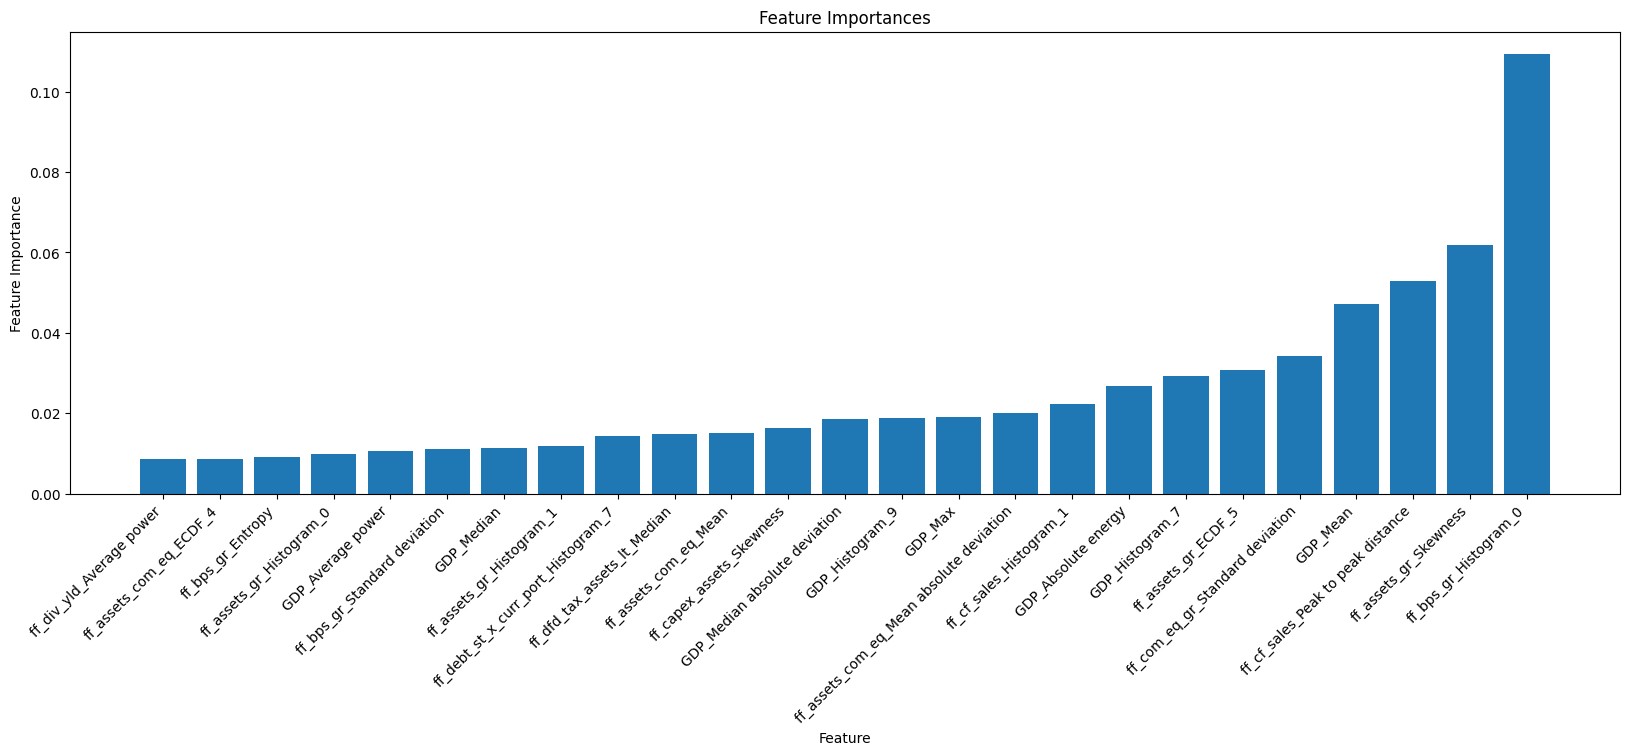

In [64]:
top_feats = feature_importances(model,feats, 'GBT')

# df2 = df.select(*top_feats, 'fsym_id', 'label')
# df2 = df.drop(*feats_to_drop)

In [ ]:
# model2, feats2, X_train2 = model_training_spark(df2, 'RandomForest')
_ = feature_importances(model2,top_feats)

In [36]:
import shap


def shapley(model, train, test, model_name):
    # train = train.toPandas()
    # test=test.toPandas()
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.KernelExplainer(model,train)
    shap_values = explainer.shap_values(test)
    shap.initjs()
    # print(shap_values.shape)
    # shap.plots.waterfall(shap_values[0])
    shap.summary_plot(shap_values,test,show=False)
    plt.tight_layout()
    plt.savefig(f'results_if/{model_name}_shap.png')
    
    
# shapley(model, train_df, test_df, model_name='rf')
    
shapley(model, X_train, X_test, model_name='MLP')

  0%|          | 0/7049 [00:00<?, ?it/s]

InvalidArgumentError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} In[0] and In[1] has different ndims: [157,2698] vs. [2698] [Op:MatMul] name: 

In [38]:
def shapley(model, train, test, feature_names, model_name):
    train_df = pd.DataFrame(train, columns=feature_names)  # Convert train to DataFrame if it's not already
    explainer = shap.DeepExplainer(model, train_df.sample(100))  # Sample from train_df
    shap_values = explainer.shap_values(test)
    shap.initjs()
    shap.summary_plot(shap_values, test, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig(f'results_if/{model_name}_shap.png')

# feats = train_df.drop(['fsym_id', 'label'], axis=1).columns.tolist()
# shapley(model, X_train, X_test, feats, model_name='MLP')


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras import layers



def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def nn_training(df):
    train_df, test_df = t_t_split(df)

    train_df = train_df.toPandas()
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows containing NaN values
    train_df.dropna(axis=0, how='any', inplace=True)
    
    test_df = test_df.toPandas()
    train_X = train_df.drop(['fsym_id', 'label'], axis=1).values
    train_y = np.array(train_df['label'])
    test_X = test_df.drop(['fsym_id', 'label'], axis=1).values
    test_y = np.array(test_df['label'])
    print(np.sum(test_y==1))
    print(train_X, train_y)
    
    class_labels = np.unique(train_y)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=train_y.flatten())
    class_weight_dict = dict(zip(class_labels, class_weights))
    print(class_weight_dict)
    

    # Define the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(train_X.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
        tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
        tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # model = keras.Sequential()
    # model.add(layers.Dense(16,activation="relu",input_shape=(train_X.shape[1],)))
    # model.add(layers.Dense(8,activation="tanh"))
    # model.add(layers.Dense(1))


    # Compile the model
    loss_fn = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(
        learning_rate=0.001
    )

    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # Train the model
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    fit_model = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_split=0.1, class_weight = class_weight_dict)
    plot_model_performance(fit_model, 'bin_cross_entropy','accuracy')

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_X, test_y)
    print(f'Test accuracy: {test_acc}')

    # Make predictions on new data
    predictions = model.predict(test_X)
    for i in range(len(predictions)):
        predictions[i] = 1 if predictions[i] >= 0.5 else 0
    print(classification_report(predictions, test_y.flatten()))
    
    # pred_df = pd.DataFrame()
    # pred_df['prediction'] = predictions
    # pred_df['label'] = test_y
    # confusion_matrix_pandas(pred_df)
    cm = confusion_matrix(test_y, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

nn_training(df)

In [ ]:
from sklearn.ensemble import IsolationForest

def anomaly_det(df):
    
    seed = 42
    train_df, test_df = t_t_split(df)
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id', 'label']
    
    
    features =train_df.columns[:-2]
    print(len(features))
    
    num_pos = len(train_df[train_df['label']==1])
    print(num_pos/len(train_df))
    isol_for = IsolationForest(contamination=num_pos/len(train_df), random_state=42)
    
    isol_for.fit(train_df[features])

    train_df['anomaly_scores'] = isol_for.decision_function(train_df[features])
    train_df['anomaly'] = isol_for.predict(train_df[features])
    train_df['preds'] = np.where(train_df['anomaly'] == 1, 0, 1)

    test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
    test_df['anomaly'] = isol_for.predict(test_df[features])
    test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)
    
    print(f"Classification Report: ")
    print(classification_report(test_df['label'], test_df['preds']))
    return test_df
    
    
test_df_isol = anomaly_det(df2)

In [ ]:
from CreateDataset import get_fund_data
import math

def plotting_stocks_pandas(df):
    imploded_stocks = df[(df['label'] == 1) & (df['preds'] == 0)]
    spark_df = spark.createDataFrame(imploded_stocks['fsym_id'].to_frame())
    imp_prices = get_fund_data(spark_df)
    
    adj_pd = imp_prices.toPandas()
    adj_pd['date'] = pd.to_datetime(adj_pd['date'])
    list_to_plot = sorted(adj_pd['fsym_id'].unique().tolist())
    
    columns = 8
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = adj_pd[adj_pd['fsym_id']==t]
        axs[i].plot(temp_df['date'], temp_df['adj_price'], label=t)

        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig('implosions_not_detected_by_model.png')
    
# print(len(test_df_isol[test_df_isol['preds']==1]))
# print(len(test_df_isol[test_df_isol['label']==1]))
# plotting_stocks_pandas(test_df_isol)   

In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=1, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
# gbt_feats = boruta_fs(df, 'gbt')

### Investigating metrics that changed the most before and after implosions

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv


def pct_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, t.Implosion_Start_Date, b.date, {big_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) = YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) = YEAR(t.Implosion_Start_Date)-1
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    #print(df1.show())
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id','Implosion_Start_Date','date'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]



    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)

    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)

    print("Largest averages of differences between previous year and implosion year: ",feats)
    return feats.index.tolist()
    
def avg_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) > YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) < YEAR(t.Implosion_Start_Date)
                GROUP BY t.fsym_id
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]


    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)
    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)
    print("Largest averages of differences in average before and after implosion date: ", feats)
#     for feature in feats.index:
#         before_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] < df1['Implosion_Start_Date'])].index)]
#         after_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] > df1['Implosion_Start_Date'])].index)]
        
#         _, p_value = ttest_ind(before_implosion, after_implosion)
        
#         print(f"T-test p-value for {feature}: {p_value}")
    return feats.index.tolist()

def t_test():
    pass


def get_metric_changes(filename, table):
    df = pd.read_csv(filename, index_col=False)
    df = df[df['Implosion_Start_Date'].notnull()]
    df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.date
    df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date']).dt.date
    cols = get_not_null_cols(df, table)
    result_string = ', '.join('(a.' + item + '-b.' + item +')/b.'+item + ' AS ' + item for item in cols)
    feats1 = pct_change_df(df, result_string, table) #change 1 year before
    print("Features with greatest percentage change with year before implosion: ", feats1)
    
    result_string2 = ', '.join('(MEAN(a.' + item + ')-MEAN(b.' + item +'))/MEAN(b.'+item + ') AS ' + item for item in cols)
    feats2 = avg_change_df(df, result_string2, table)
    print("Features with greatest percentage change in mean before and after implosion", feats2)
    
    write_features_file( list(set(feats1+feats2)) )


get_metric_changes('imploded_stocks_price.csv', 'FF_ADVANCED_DER_AF')


### Correlations with Market Value Returns

In [ ]:
import csv
from CreateDataset import get_feature_col_names, get_fund_data


def corr_query(implosion_df, col_string, table): 
    df = get_fund_data(implosion_df)
    df=df.withColumn('year', F.year('date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1).orderBy('date') #should we compare correlations with market val?
    #should we do quarterly?
    
    df.createOrReplaceTempView("temp_table")
    query1 = f"""
                SELECT t.fsym_id, t.adj_price, t.Market_Value, t.date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.date
            """
 
    q_df = spark.sql(query1)
    #q_df.show()
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    
    q_df = q_df.withColumn("return_market_val", (F.col('Market_Value') - F.lag('Market_Value').over(window_spec)) / F.lag('Market_Value').over(window_spec))
    q_df = q_df.withColumn("return", (F.col('adj_price') - F.lag('adj_price').over(window_spec)) / F.lag('adj_price').over(window_spec))
    
    return_columns = [c[2:] for c in col_string.split(", ")]
    mean_corrs = []
    corr_vals = []
    #I THINK U NEED TO GROUP BY DATE AND THEN CALCULATE CORRELATIONS

    for column in return_columns:
        return_col_name = f"return_{column}"
        corr_col_name = f"corr_with_{column}"
        q_df = q_df.withColumn(return_col_name, (F.col(column) - F.lag(column).over(window_spec)) / F.lag(column).over(window_spec))
        q_df = q_df.withColumn(column, F.corr(return_col_name, 'return_market_val').over(window_spec)) #calculating correlations with market value return
        q_df = q_df.drop(*[return_col_name])
    q_df = q_df.drop(*['return_market_val', 'return'])
    q_df = q_df.select(q_df.columns[4:])
    mean_corrs = q_df.agg(*[F.mean(F.abs(F.col(column))).alias(column) for column in q_df.columns])
    # mean_corrs.show()
    
    return mean_corrs.toPandas()

def corr_analysis(table):
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    result_string = ', '.join('a.' + item for item in cols)
    mean_corrs_df = corr_query(spark.createDataFrame(imp_df_price), result_string, 'FF_ADVANCED_DER_AF')
    mean_corrs = mean_corrs_df.to_dict(orient='records')
    sorted_corrs = dict(sorted(mean_corrs[0].items(), key=lambda item: item[1], reverse=True))
    top_records = list(sorted_corrs.items())[:5]
    top_10 = []
    for r in top_records:
        top_10.append(r[0])
    print(top_10)
    current_feature_list = get_feature_col_names()
    new_feature_list = list(set(current_feature_list + top_10))
    
    write_features_file(new_feature_list)
    
    
corr_analysis('FF_Advanced_Der_AF')

### Adding the Extra Features From Literature

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
available_feats = get_not_null_cols(imp_df_price)
extra_feats = ['ff_capex_assets', 'ff_gross_cf_debt', 'ff_mkt_val_gr']

current_feats = get_feature_col_names()
final_feats = list(set(current_feats + extra_feats))
write_features_file(final_feats)

### Boruta

In [ ]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

df = get_df()


In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
gbt_feats = boruta_fs(df, 'gbt')

In [ ]:
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [ ]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
feats

### Extra

In [ ]:
def start_dates(imp_df_price):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    #cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    #result_string = ', '.join('a.' + item for item in cols)
    
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date'))

    price_data = price_data.withColumn('row_num', F.row_number().over(window_spec))
    price_data.show()

    price_data = price_data.filter(col('row_num') == 1).orderBy(col('p_date').desc())
    price_data.show()
    
    start_dates = price_data.groupBy('year').count().orderBy('year')
    years = [row['year'] for row in start_dates.collect()]
    counts = [row['count'] for row in start_dates.collect()]
    plt.bar(years, counts)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Start Dates Count per Year')
    plt.show()
    #start_dates.show(25)
    
def null_vals(imp_df_price, table):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    cols = get_not_null_cols(imp_df_price, table)
    col_string = ', '.join('a.' + item for item in cols)
    price_data.createOrReplaceTempView('temp_table')
    null_counts = []
    query1 = f"""
                SELECT t.fsym_id, t.split_adj_price, t.Market_Value, t.p_date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.p_date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.p_date
            """
    full_df = spark.sql(query1)
    for column in cols:
        null_count = full_df.select(column).filter(col(column).isNull()).count()
        null_counts.append((column, null_count))
    null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'Null Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(null_counts_df['Column'], null_counts_df['Null Count'])
    plt.xlabel('Column')
    plt.ylabel('Null Count')
    plt.title('Null Counts for Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # null_counts = price_data.groupBy('year').agg(F.sum(col('p_price').isNull().cast('int')).alias('null_count'))
    # null_counts.show()
    
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price_imploded = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
start_dates(imp_df_price)
start_dates(imp_df_price_imploded)

#null_vals(imp_df_price, 'FF_ADVANCED_DER_AF')

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_test = imp_df_price[imp_df_price['fsym_id']=='H7CTYF-R']
df = get_fund_data(spark.createDataFrame(imp_df_test))
df.show(1000)
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))

In [ ]:
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))
print(len(imp_df_price))

In [ ]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols

#%change average of each feature plotted for pharmacy industry
def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

#industry_analysis()

In [ ]:

#YOU'VE DONE WORST CHANGES NOW FIND OUT WHICH ONES DECREASE CONSISTENTLY
#ALSO FIGURE OUT MEANS BEFORE PERIOD AND AFTER PERIOD USING QUARTERLY AND COMPARE DIFF
#FINALLY WITH A HUGE LIST USE BORUTA

In [ ]:
def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    column_types = q_df.dtypes
    null_pcts = []
    for c, dtype in zip(q_df.columns, column_types):
        if dtype[1] == 'double':
            null_count = q_df.filter(F.col(c).isNull()).count()
            null_pcts.append(null_count/q_df.count())


    columns_to_drop = [col_name for col_name, null_pct, dtype in zip(q_df.columns, null_pcts, column_types) if null_pct > 0.2 or dtype[1]!='double']

    q_df = q_df.drop(*columns_to_drop)

    cols = q_df.columns
    print(cols)

    return cols
    
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df = df.loc[df['Implosion_Start_Date'].notnull()]
get_not_null_cols(df)

In [ ]:
spark.stop()